In [2]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 16.3 MB/s eta 0:00:00


In [3]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [4]:
def rescale_frame(frame, percent=50):

    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)


def describe_dataset(dataset_path: str):

    # Load dataset
    data = pd.read_csv(dataset_path)

    # Print basic information about the dataset
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")

    # Check for missing values
    print(f"Missing values: {data.isnull().values.any()}\n")

    # Check for duplicate rows
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows: {len(duplicate)}\n")

    # Ensure numeric columns are properly converted to float
    numeric_columns = data.columns.drop('label')  # Assuming 'label' is non-numeric
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Print data types to verify conversions
    print("Column data types after conversion:")
    print(data.dtypes)

    # Check for any remaining NaN values after conversion
    if data.isnull().values.any():
        print(f"\nWarning: There are NaN values in the dataset after conversion.")
        print(data.isnull().sum())

    return data

In [5]:
df = describe_dataset("/content/stage.train.csv")
df.head(3)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 24244 
Number of columns: 53

Labels: 
label
D    8232
M    8148
I    7864
Name: count, dtype: int64


,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
0,M,0.496085,0.286904,-0.219098,0.999996,0.500287,0.360987,0.019479,0.999978,0.436462,...,-0.268695,0.996758,0.370391,0.893386,0.505172,0.931761,0.566927,1.005949,-0.382462,0.998906
1,M,0.496126,0.286918,-0.217849,0.999996,0.500281,0.360954,0.019995,0.999977,0.436466,...,-0.271191,0.996724,0.370344,0.893290,0.505325,0.931969,0.567040,1.005795,-0.384848,0.998902
2,M,0.496144,0.286921,-0.217039,0.999996,0.500279,0.360923,0.020068,0.999977,0.436469,...,-0.271365,0.996699,0.370316,0.893275,0.504931,0.931633,0.567040,1.005774,-0.384872,0.998894


In [6]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

In [7]:
# Extract features and class
X = df.drop("label", axis=1) # features
Y = df["label"]

# Standard Scaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))
#X.head(3)
Y.head(3)

,label
0,M
1,M
2,M


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32)

Y_train.head(3)

,label
17428,D
7187,D
12405,I


Logistic Regression

In [9]:
# Train the model
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Evaluate the model
lr_precision = precision_score(Y_test, lr_predictions, average="macro")
lr_accuracy = accuracy_score(Y_test, lr_predictions)
lr_recall = recall_score(Y_test, lr_predictions, average="macro")
lr_f1 = f1_score(Y_test, lr_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Logistic Regression - Precision: {lr_precision:.3f}, Accuracy: {lr_accuracy:.3f}, Recall: {lr_recall:.3f}")
print(f"Logistic Regression - F1-Scores: I: {lr_f1[0]:.3f}, M: {lr_f1[1]:.3f}, D: {lr_f1[2]:.3f}")


Logistic Regression - Precision: 0.991, Accuracy: 0.991, Recall: 0.991
Logistic Regression - F1-Scores: I: 0.996, M: 0.986, D: 0.990


SVC

In [10]:
# Train the model
svc_model = SVC(probability=True)
svc_model.fit(X_train, Y_train)

# Make predictions
svc_predictions = svc_model.predict(X_test)

# Evaluate the model
svc_precision = precision_score(Y_test, svc_predictions, average="macro")
svc_accuracy = accuracy_score(Y_test, svc_predictions)
svc_recall = recall_score(Y_test, svc_predictions, average="macro")
svc_f1 = f1_score(Y_test, svc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"SVC - Precision: {svc_precision:.3f}, Accuracy: {svc_accuracy:.3f}, Recall: {svc_recall:.3f}")
print(f"SVC - F1-Scores: I: {svc_f1[0]:.3f}, M: {svc_f1[1]:.3f}, D: {svc_f1[2]:.3f}")


SVC - Precision: 0.995, Accuracy: 0.994, Recall: 0.995
SVC - F1-Scores: I: 0.998, M: 0.992, D: 0.994


K-NN

In [11]:
# Train the model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, Y_train)

# Make predictions
knn_predictions = knn_model.predict(X_test)

# Evaluate the model
knn_precision = precision_score(Y_test, knn_predictions, average="macro")
knn_accuracy = accuracy_score(Y_test, knn_predictions)
knn_recall = recall_score(Y_test, knn_predictions, average="macro")
knn_f1 = f1_score(Y_test, knn_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"KNN - Precision: {knn_precision:.3f}, Accuracy: {knn_accuracy:.3f}, Recall: {knn_recall:.3f}")
print(f"KNN - F1-Scores: I: {knn_f1[0]:.3f}, M: {knn_f1[1]:.3f}, D: {knn_f1[2]:.3f}")


KNN - Precision: 0.997, Accuracy: 0.997, Recall: 0.997
KNN - F1-Scores: I: 0.999, M: 0.996, D: 0.997


Decision Tree Classifier

In [12]:
# Train the model
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, Y_train)

# Make predictions
dtc_predictions = dtc_model.predict(X_test)

# Evaluate the model
dtc_precision = precision_score(Y_test, dtc_predictions, average="macro")
dtc_accuracy = accuracy_score(Y_test, dtc_predictions)
dtc_recall = recall_score(Y_test, dtc_predictions, average="macro")
dtc_f1 = f1_score(Y_test, dtc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Decision Tree - Precision: {dtc_precision:.3f}, Accuracy: {dtc_accuracy:.3f}, Recall: {dtc_recall:.3f}")
print(f"Decision Tree - F1-Scores: I: {dtc_f1[0]:.3f}, M: {dtc_f1[1]:.3f}, D: {dtc_f1[2]:.3f}")


Decision Tree - Precision: 0.993, Accuracy: 0.993, Recall: 0.993
Decision Tree - F1-Scores: I: 0.996, M: 0.990, D: 0.994


SDGC

In [13]:
# Train the model
sgdc_model = SGDClassifier()
sgdc_model.fit(X_train, Y_train)

# Make predictions
sgdc_predictions = sgdc_model.predict(X_test)

# Evaluate the model
sgdc_precision = precision_score(Y_test, sgdc_predictions, average="macro")
sgdc_accuracy = accuracy_score(Y_test, sgdc_predictions)
sgdc_recall = recall_score(Y_test, sgdc_predictions, average="macro")
sgdc_f1 = f1_score(Y_test, sgdc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"SGD Classifier - Precision: {sgdc_precision:.3f}, Accuracy: {sgdc_accuracy:.3f}, Recall: {sgdc_recall:.3f}")
print(f"SGD Classifier - F1-Scores: I: {sgdc_f1[0]:.3f}, M: {sgdc_f1[1]:.3f}, D: {sgdc_f1[2]:.3f}")


SGD Classifier - Precision: 0.989, Accuracy: 0.988, Recall: 0.988
SGD Classifier - F1-Scores: I: 0.992, M: 0.983, D: 0.991


Ridge Classifier

In [14]:
# Train the model
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, Y_train)

# Make predictions
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the model
ridge_precision = precision_score(Y_test, ridge_predictions, average="macro")
ridge_accuracy = accuracy_score(Y_test, ridge_predictions)
ridge_recall = recall_score(Y_test, ridge_predictions, average="macro")
ridge_f1 = f1_score(Y_test, ridge_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Ridge Classifier - Precision: {ridge_precision:.3f}, Accuracy: {ridge_accuracy:.3f}, Recall: {ridge_recall:.3f}")
print(f"Ridge Classifier - F1-Scores: I: {ridge_f1[0]:.3f}, M: {ridge_f1[1]:.3f}, D: {ridge_f1[2]:.3f}")


Ridge Classifier - Precision: 0.976, Accuracy: 0.975, Recall: 0.974
Ridge Classifier - F1-Scores: I: 0.976, M: 0.964, D: 0.985


Random Forest Classifier

In [15]:
# Train the model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_precision = precision_score(Y_test, rf_predictions, average="macro")
rf_accuracy = accuracy_score(Y_test, rf_predictions)
rf_recall = recall_score(Y_test, rf_predictions, average="macro")
rf_f1 = f1_score(Y_test, rf_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Random Forest - Precision: {rf_precision:.3f}, Accuracy: {rf_accuracy:.3f}, Recall: {rf_recall:.3f}")
print(f"Random Forest - F1-Scores: I: {rf_f1[0]:.3f}, M: {rf_f1[1]:.3f}, D: {rf_f1[2]:.3f}")


Random Forest - Precision: 0.996, Accuracy: 0.996, Recall: 0.996
Random Forest - F1-Scores: I: 0.996, M: 0.994, D: 0.997


In [16]:
import pandas as pd

# Assuming final_results is a list of tuples with the model results
final_results = [
    ("Logistic Regression", lr_precision, lr_accuracy, lr_recall, lr_f1),
    ("SVC", svc_precision, svc_accuracy, svc_recall, svc_f1),
    ("KNN", knn_precision, knn_accuracy, knn_recall, knn_f1),
    ("Decision Tree", dtc_precision, dtc_accuracy, dtc_recall, dtc_f1),
    ("SGD Classifier", sgdc_precision, sgdc_accuracy, sgdc_recall, sgdc_f1),
    ("Ridge Classifier", ridge_precision, ridge_accuracy, ridge_recall, ridge_f1),
    ("Random Forest", rf_precision, rf_accuracy, rf_recall, rf_f1),
]

# Create a DataFrame
results_df = pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy Score", "Recall Score", "F1 Score"])

# Display the DataFrame
print(results_df)


                 Model  Precision Score  Accuracy Score  Recall Score  \
0  Logistic Regression         0.990936        0.990720      0.990854   
1                  SVC         0.994584        0.994432      0.994524   
2                  KNN         0.997386        0.997319      0.997378   
3        Decision Tree         0.993211        0.993194      0.993302   
4       SGD Classifier         0.988587        0.988451      0.988482   
5     Ridge Classifier         0.975881        0.974840      0.974130   
6        Random Forest         0.995832        0.995875      0.995908   

                                            F1 Score  
0  [0.9963369963369964, 0.9863180297962907, 0.990...  
1  [0.9983361064891847, 0.9917758148035334, 0.993...  
2  [0.9993351063829787, 0.9960353766392193, 0.996...  
3  [0.9956824975091332, 0.9902498476538696, 0.993...  
4  [0.9920053297801465, 0.9829787234042553, 0.990...  
5  [0.9762389680923286, 0.963609022556391, 0.9845...  
6  [0.9963467286615743, 0.9939

In [18]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", SGDClassifier()),
         ("Ridge", RidgeClassifier()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average="macro")
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average="macro")
    f1_score_result = f1_score(y_test, model_results, average=None, labels=["I", "M", "D"])
    final_results.append(( name, p_score, a_score, r_score, f1_score_result ))


final_results.sort(key=lambda k: k[4][0] + k[4][1], reverse=True)
print(model_results)

NameError: name 'y_train' is not defined

In [19]:
test_df = describe_dataset("/content/stage.test.csv")
test_df = test_df.sample(frac=1).reset_index(drop=True)

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"]

test_x = pd.DataFrame(sc.transform(test_x))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1205 
Number of columns: 53

Labels: 
label
D    416
I    402
M    387
Name: count, dtype: int64

Mis

In [20]:
# Make predictions
lr_predictions = lr_model.predict(test_x)  # Predict on the test data

# Evaluate the model
lr_precision = precision_score(test_y, lr_predictions, average="macro")
lr_accuracy = accuracy_score(test_y, lr_predictions)
lr_recall = recall_score(test_y, lr_predictions, average="macro")
lr_f1 = f1_score(test_y, lr_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Logistic Regression - Precision: {lr_precision:.3f}, Accuracy: {lr_accuracy:.3f}, Recall: {lr_recall:.3f}")
print(f"Logistic Regression - F1-Scores: I: {lr_f1[0]:.3f}, M: {lr_f1[1]:.3f}, D: {lr_f1[2]:.3f}")


Logistic Regression - Precision: 0.956, Accuracy: 0.952, Recall: 0.950
Logistic Regression - F1-Scores: I: 0.955, M: 0.919, D: 0.976


In [21]:
# Support Vector Classifier (SVC)
svc_predictions = svc_model.predict(test_x)

# Evaluate the model
svc_precision = precision_score(test_y, svc_predictions, average="macro")
svc_accuracy = accuracy_score(test_y, svc_predictions)
svc_recall = recall_score(test_y, svc_predictions, average="macro")
svc_f1 = f1_score(test_y, svc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"SVC - Precision: {svc_precision:.3f}, Accuracy: {svc_accuracy:.3f}, Recall: {svc_recall:.3f}")
print(f"SVC - F1-Scores: I: {svc_f1[0]:.3f}, M: {svc_f1[1]:.3f}, D: {svc_f1[2]:.3f}")


SVC - Precision: 0.956, Accuracy: 0.952, Recall: 0.950
SVC - F1-Scores: I: 0.947, M: 0.919, D: 0.985


In [22]:
# K-Nearest Neighbors (KNN)
knn_predictions = knn_model.predict(test_x)

# Evaluate the model
knn_precision = precision_score(test_y, knn_predictions, average="macro")
knn_accuracy = accuracy_score(test_y, knn_predictions)
knn_recall = recall_score(test_y, knn_predictions, average="macro")
knn_f1 = f1_score(test_y, knn_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"KNN - Precision: {knn_precision:.3f}, Accuracy: {knn_accuracy:.3f}, Recall: {knn_recall:.3f}")
print(f"KNN - F1-Scores: I: {knn_f1[0]:.3f}, M: {knn_f1[1]:.3f}, D: {knn_f1[2]:.3f}")


KNN - Precision: 0.915, Accuracy: 0.910, Recall: 0.912
KNN - F1-Scores: I: 0.970, M: 0.868, D: 0.891


In [23]:
# Decision Tree Classifier (DTC)
dtc_predictions = dtc_model.predict(test_x)

# Evaluate the model
dtc_precision = precision_score(test_y, dtc_predictions, average="macro")
dtc_accuracy = accuracy_score(test_y, dtc_predictions)
dtc_recall = recall_score(test_y, dtc_predictions, average="macro")
dtc_f1 = f1_score(test_y, dtc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"DTC - Precision: {dtc_precision:.3f}, Accuracy: {dtc_accuracy:.3f}, Recall: {dtc_recall:.3f}")
print(f"DTC - F1-Scores: I: {dtc_f1[0]:.3f}, M: {dtc_f1[1]:.3f}, D: {dtc_f1[2]:.3f}")


DTC - Precision: 0.838, Accuracy: 0.835, Recall: 0.832
DTC - F1-Scores: I: 0.882, M: 0.719, D: 0.884


In [24]:
# SGD Classifier
sgdc_predictions = sgdc_model.predict(test_x)

# Evaluate the model
sgdc_precision = precision_score(test_y, sgdc_predictions, average="macro")
sgdc_accuracy = accuracy_score(test_y, sgdc_predictions)
sgdc_recall = recall_score(test_y, sgdc_predictions, average="macro")
sgdc_f1 = f1_score(test_y, sgdc_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"SGD Classifier - Precision: {sgdc_precision:.3f}, Accuracy: {sgdc_accuracy:.3f}, Recall: {sgdc_recall:.3f}")
print(f"SGD Classifier - F1-Scores: I: {sgdc_f1[0]:.3f}, M: {sgdc_f1[1]:.3f}, D: {sgdc_f1[2]:.3f}")


SGD Classifier - Precision: 0.927, Accuracy: 0.920, Recall: 0.918
SGD Classifier - F1-Scores: I: 0.913, M: 0.866, D: 0.976


In [25]:
# Ridge Classifier
ridge_predictions = ridge_model.predict(test_x)

# Evaluate the model
ridge_precision = precision_score(test_y, ridge_predictions, average="macro")
ridge_accuracy = accuracy_score(test_y, ridge_predictions)
ridge_recall = recall_score(test_y, ridge_predictions, average="macro")
ridge_f1 = f1_score(test_y, ridge_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Ridge Classifier - Precision: {ridge_precision:.3f}, Accuracy: {ridge_accuracy:.3f}, Recall: {ridge_recall:.3f}")
print(f"Ridge Classifier - F1-Scores: I: {ridge_f1[0]:.3f}, M: {ridge_f1[1]:.3f}, D: {ridge_f1[2]:.3f}")


Ridge Classifier - Precision: 0.954, Accuracy: 0.952, Recall: 0.950
Ridge Classifier - F1-Scores: I: 0.975, M: 0.922, D: 0.956


In [26]:
# Random Forest Classifier
rf_predictions = rf_model.predict(test_x)

# Evaluate the model
rf_precision = precision_score(test_y, rf_predictions, average="macro")
rf_accuracy = accuracy_score(test_y, rf_predictions)
rf_recall = recall_score(test_y, rf_predictions, average="macro")
rf_f1 = f1_score(test_y, rf_predictions, average=None, labels=["I", "M", "D"])

# Display results
print(f"Random Forest - Precision: {rf_precision:.3f}, Accuracy: {rf_accuracy:.3f}, Recall: {rf_recall:.3f}")
print(f"Random Forest - F1-Scores: I: {rf_f1[0]:.3f}, M: {rf_f1[1]:.3f}, D: {rf_f1[2]:.3f}")


Random Forest - Precision: 0.876, Accuracy: 0.870, Recall: 0.869
Random Forest - F1-Scores: I: 0.902, M: 0.791, D: 0.909


In [27]:
# Assuming final_results is a list of tuples with the model results
final_results = [
    ("Logistic Regression", lr_precision, lr_accuracy, lr_recall, lr_f1),
    ("SVC", svc_precision, svc_accuracy, svc_recall, svc_f1),
    ("KNN", knn_precision, knn_accuracy, knn_recall, knn_f1),
    ("Decision Tree", dtc_precision, dtc_accuracy, dtc_recall, dtc_f1),
    ("SGD Classifier", sgdc_precision, sgdc_accuracy, sgdc_recall, sgdc_f1),
    ("Ridge Classifier", ridge_precision, ridge_accuracy, ridge_recall, ridge_f1),
    ("Random Forest", rf_precision, rf_accuracy, rf_recall, rf_f1),
]

# Create a DataFrame
results_df = pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy Score", "Recall Score", "F1 Score"])

# Display the DataFrame
print(results_df)

                 Model  Precision Score  Accuracy Score  Recall Score  \
0  Logistic Regression         0.955612        0.951867      0.950103   
1                  SVC         0.955814        0.951867      0.950163   
2                  KNN         0.915411        0.910373      0.911600   
3        Decision Tree         0.838305        0.834855      0.832499   
4       SGD Classifier         0.926643        0.920332      0.918366   
5     Ridge Classifier         0.953882        0.951867      0.950457   
6        Random Forest         0.876499        0.869710      0.868795   

                                            F1 Score  
0  [0.9548693586698337, 0.9192200557103064, 0.976...  
1  [0.9469964664310954, 0.9194444444444444, 0.984...  
2  [0.9698431845597105, 0.8682926829268293, 0.890...  
3   [0.881578947368421, 0.71875, 0.8841309823677582]  
4  [0.9134396355353075, 0.865546218487395, 0.9755...  
5  [0.9750623441396509, 0.9216216216216216, 0.956...  
6  [0.9023569023569024, 0.7909

In [28]:
test_df = describe_dataset("./stage.test.csv")
test_df = test_df.sample(frac=1).reset_index(drop=True)

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"]

test_x = pd.DataFrame(sc.transform(test_x))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1205 
Number of columns: 53

Labels: 
label
D    416
I    402
M    387
Name: count, dtype: int64

Mis

In [29]:
import pickle
import os

# Create a directory in Colab to save your models
save_directory = '/Lunges_FYP_Model'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the SVC model
with open(os.path.join(save_directory, 'svc_model.pkl'), 'wb') as svc_file:
    pickle.dump(svc_model, svc_file)

# Save the Logistic Regression model
with open(os.path.join(save_directory, 'logistic_regression_model.pkl'), 'wb') as lr_file:
    pickle.dump(lr_model, lr_file)

# Save the Standard Scaler
with open(os.path.join(save_directory, 'input_scaler.pkl'), 'wb') as scaler_file:
    pickle.dump(sc, scaler_file)

print("Models and scaler saved successfully!")

# Zip the directory
!zip -r Lunges_FYP_Model.zip /Lunges_FYP_Model

# Download the zip file
from google.colab import files
files.download('Lunges_FYP_Model.zip')


Models and scaler saved successfully!
  adding: Lunges_FYP_Model/ (stored 0%)
  adding: Lunges_FYP_Model/input_scaler.pkl (deflated 29%)
  adding: Lunges_FYP_Model/svc_model.pkl (deflated 8%)
  adding: Lunges_FYP_Model/logistic_regression_model.pkl (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deep Learning

In [30]:
# Data visualization
import numpy as np
import pandas as pd
# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

# Train-Test
from sklearn.model_selection import train_test_split
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import cv2

def rescale_frame(frame, percent=50):

    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)


def describe_dataset(dataset_path: str, remove_duplicates: bool = True):

    # Load dataset
    data = pd.read_csv(dataset_path)

    # Print basic information about the dataset
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")

    # Check for missing values
    print(f"Missing values: {data.isnull().values.any()}\n")

    # Check for duplicate rows
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows: {len(duplicate)}\n")

    # Remove duplicate rows if option is enabled
    if remove_duplicates:
        initial_rows = data.shape[0]
        data.drop_duplicates(keep="first", inplace=True)
        final_rows = data.shape[0]
        print(f"Removed {initial_rows - final_rows} duplicate rows.\n")

    # Ensure numeric columns are properly converted to float
    numeric_columns = data.columns.drop('label')  # Assuming 'label' is non-numeric
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Print data types to verify conversions
    print("Column data types after conversion:")
    print(data.dtypes)

    # Check for any remaining NaN values after conversion
    if data.isnull().values.any():
        print(f"\nWarning: There are NaN values in the dataset after conversion.")
        print(data.isnull().sum())

    return data

# Example usage
df = describe_dataset("/content/stage.train.csv", remove_duplicates=True)
df.head(3)


Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 24244 
Number of columns: 53

Labels: 
label
D    8232
M    8148
I    7864
Name: count, dtype: int64


,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
0,M,0.496085,0.286904,-0.219098,0.999996,0.500287,0.360987,0.019479,0.999978,0.436462,...,-0.268695,0.996758,0.370391,0.893386,0.505172,0.931761,0.566927,1.005949,-0.382462,0.998906
1,M,0.496126,0.286918,-0.217849,0.999996,0.500281,0.360954,0.019995,0.999977,0.436466,...,-0.271191,0.996724,0.370344,0.893290,0.505325,0.931969,0.567040,1.005795,-0.384848,0.998902
2,M,0.496144,0.286921,-0.217039,0.999996,0.500279,0.360923,0.020068,0.999977,0.436469,...,-0.271365,0.996699,0.370316,0.893275,0.504931,0.931633,0.567040,1.005774,-0.384872,0.998894


In [ ]:
# load dataset
df = pd.read_csv("/content/stage.train.csv")

# Categorizing label
df.loc[df["label"] == "I", "label"] = 0
df.loc[df["label"] == "M", "label"] = 1
df.loc[df["label"] == "D", "label"] = 2

print(f'Number of rows: {df.shape[0]} \nNumber of columns: {df.shape[1]}\n')
print(f"Labels: \n{df['label'].value_counts()}\n")

Number of rows: 24244 
Number of columns: 53

Labels: 
label
2    8232
1    8148
0    7864
Name: count, dtype: int64



In [ ]:
# Standard Scaling of features
with open("/content/input_scaler.pkl", "rb") as f2:
    input_scaler = pickle.load(f2)

x = df.drop("label", axis = 1)
x = pd.DataFrame(input_scaler.transform(x))

y = df["label"]

# # Converting prediction to categorical
y_cat = to_categorical(y)

FileNotFoundError: [Errno 2] No such file or directory: '/content/input_scaler.pkl'

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat, test_size=0.2)

In [ ]:

model = Sequential()
model.add(Dense(52, input_dim = 52, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(52, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(14, activation = "relu"))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(learning_rate = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 52)                  │           2,756 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 52)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 52)                  │           2,756 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 52)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 14)                  │             742 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,299 (24.61 KB)

 Trainable params: 6,299 (24.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9054 - loss: 0.2741 - val_accuracy: 0.9676 - val_loss: 0.0982
Epoch 2/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9712 - loss: 0.1201 - val_accuracy: 0.9868 - val_loss: 0.0517
Epoch 3/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9767 - loss: 0.1028 - val_accuracy: 0.9887 - val_loss: 0.0544
Epoch 4/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9728 - loss: 0.1215 - val_accuracy: 0.9895 - val_loss: 0.0447
Epoch 5/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9788 - loss: 0.0922 - val_accuracy: 0.9783 - val_loss: 0.0650
Epoch 6/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9747 - loss: 0.1107 - val_accuracy: 0.9839 - val_loss: 0.0672
Epoch 7/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9772 - loss: 0.1116 - val_accuracy: 0.9849 - val_loss: 0.0656
Epoch 8/100
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9798 - loss:

In [ ]:
predict_x = model.predict(x_test)
y_pred_class = np.argmax(predict_x, axis=1)

y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test, axis=1)

confusion_matrix(y_test_class, y_pred_class)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[1602,   11,    0],
       [   5, 1590,   19],
       [   2,   14, 1606]])

In [ ]:
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1613
           1       0.98      0.99      0.98      1614
           2       0.99      0.99      0.99      1622

    accuracy                           0.99      4849
   macro avg       0.99      0.99      0.99      4849
weighted avg       0.99      0.99      0.99      4849



In [ ]:

test_df = pd.read_csv("/content/stage.test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "I", "label"] = 0
test_df.loc[test_df["label"] == "M", "label"] = 1
test_df.loc[test_df["label"] == "D", "label"] = 2

In [ ]:
# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(input_scaler.transform(test_x))

test_y = test_df["label"]

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

In [ ]:
predict_x = model.predict(test_x)
y_pred_class = np.argmax(predict_x, axis=1)
y_test_class = np.argmax(test_y_cat, axis=1)

confusion_matrix(y_test_class, y_pred_class)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[401,   1,   0],
       [ 54, 327,   6],
       [  0,  18, 398]])

In [ ]:
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       402
           1       0.95      0.84      0.89       387
           2       0.99      0.96      0.97       416

    accuracy                           0.93      1205
   macro avg       0.94      0.93      0.93      1205
weighted avg       0.94      0.93      0.93      1205



In [ ]:
import pickle
import os

# Create a directory in Colab to save your models
save_directory = 'Lunges_FYP_Model/Deep_Learning_Model'  # Removed leading slash

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the model
with open(os.path.join(save_directory, 'Lunges_Deep_Learning_Model.pkl'), 'wb') as svc_file:
    pickle.dump(model, svc_file)  # Ensure 'model' is defined

print("Model saved successfully!")

# Zip the directory
!zip -r Lunges_FYP_Model.zip Lunges_FYP_Model  # Removed leading slash

# Download the zip file
from google.colab import files
files.download('Lunges_FYP_Model.zip')


Model saved successfully!
updating: Lunges_FYP_Model/ (stored 0%)
updating: Lunges_FYP_Model/Deep_Learning_Model/ (stored 0%)
updating: Lunges_FYP_Model/Deep_Learning_Model/Lunges_Deep_Learning_Model.pkl (deflated 30%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import pickle
import mediapipe as mp
import traceback
from google.colab.patches import cv2_imshow  # For displaying images in Colab
from google.colab import files

# Upload files
#uploaded = files.upload()

# Load models
with open("/content/stage_SVC_model.pkl", "rb") as f:
    stage_sklearn_model = pickle.load(f)

with open("/content/err_LR_model.pkl", "rb") as f:
    err_sklearn_model = pickle.load(f)

# Load input scaler
with open("/content/input_scaler.pkl", "rb") as f:
    input_scaler = pickle.load(f)

# Define constants
VIDEO_PATH = "/content/6525491-hd_1920_1080_25fps.mp4"  # Adjusted to the uploaded file name

# Define the header column based on important landmarks
HEADERS = []  # Start with an empty list for headers

# IMPORTANT_LMS defined without duplication
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX",
]

# Add landmark features to the HEADERS without the label
for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

# Check header length
if len(HEADERS) != len(IMPORTANT_LMS) * 4:  # 4 for each landmark only
    raise ValueError(f"Expected {len(IMPORTANT_LMS) * 4} headers, but got {len(HEADERS)}. Please check IMPORTANT_LMS.")

ANGLE_THRESHOLDS = [60, 135]
prediction_probability_threshold = 0.8
counter = 0
current_stage = ""

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(VIDEO_PATH)

def extract_important_keypoints(results) -> list:
    landmarks = results.pose_landmarks.landmark
    data = []
    landmark_mapping = {name: mp_pose.PoseLandmark[name].value for name in IMPORTANT_LMS}

    for lm in IMPORTANT_LMS:
        keypoint = landmarks[landmark_mapping[lm]]
        data.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])

    return np.array(data).flatten().tolist()

def rescale_frame(frame, percent=50):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

def calculate_angle(point1: list, point2: list, point3: list) -> float:
    point1 = np.array(point1)
    point2 = np.array(point2)
    point3 = np.array(point3)
    angleInRad = np.arctan2(point3[1] - point2[1], point3[0] - point2[0]) - np.arctan2(point1[1] - point2[1], point1[0] - point2[0])
    angleInDeg = np.abs(angleInRad * 180.0 / np.pi)
    angleInDeg = angleInDeg if angleInDeg <= 180 else 360 - angleInDeg
    return angleInDeg

def analyze_knee_angle(mp_results, stage: str, angle_thresholds: list):
    results = {"error": None, "right": {"error": None, "angle": None}, "left": {"error": None, "angle": None}}
    landmarks = mp_results.pose_landmarks.landmark

    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    results["right"]["angle"] = calculate_angle(right_hip, right_knee, right_ankle)

    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    results["left"]["angle"] = calculate_angle(left_hip, left_knee, left_ankle)

    if stage == "down":
        results["error"] = False
        if angle_thresholds[0] <= results["right"]["angle"] <= angle_thresholds[1]:
            results["right"]["error"] = False
        else:
            results["right"]["error"] = True
            results["error"] = True

        if angle_thresholds[0] <= results["left"]["angle"] <= angle_thresholds[1]:
            results["left"]["error"] = False
        else:
            results["left"]["error"] = True
            results["error"] = True

    return results

# Start pose detection
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        image = rescale_frame(image, 50)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)

        if not results.pose_landmarks:
            print("No human found")
            continue

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        try:
            row = extract_important_keypoints(results)
            X = pd.DataFrame([row], columns=HEADERS)
            X = pd.DataFrame(input_scaler.transform(X))

            stage_predicted_class = stage_sklearn_model.predict(X)[0]
            stage_prediction_probabilities = stage_sklearn_model.predict_proba(X)[0]
            stage_prediction_probability = round(stage_prediction_probabilities[stage_prediction_probabilities.argmax()], 2)

            if stage_predicted_class == "I" and stage_prediction_probability >= prediction_probability_threshold:
                current_stage = "init"
            elif stage_predicted_class == "M" and stage_prediction_probability >= prediction_probability_threshold:
                current_stage = "mid"
            elif stage_predicted_class == "D" and stage_prediction_probability >= prediction_probability_threshold:
                if current_stage in ["mid", "init"]:
                    current_stage = "down"
                else:
                    current_stage = "up"

            knee_analysis_results = analyze_knee_angle(results, current_stage, ANGLE_THRESHOLDS)

            if knee_analysis_results["error"]:
                counter += 1
                cv2.putText(image, "Correct the form!", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)
            else:
                counter = 0

            if counter >= 5:
                cv2.putText(image, "ERROR: Incorrect form!", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)

            cv2.putText(image, f"Stage: {current_stage}", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv2.LINE_AA)
            cv2.putText(image, f"Right Knee Angle: {knee_analysis_results['right']['angle']:.2f}", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f"Left Knee Angle: {knee_analysis_results['left']['angle']:.2f}", (10, 350), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2_imshow(image)

        except Exception as e:
            print(traceback.format_exc())

cap.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Display each header
for header in HEADERS:
    print(header)


label
nose_x
nose_y
nose_z
nose_v
left_shoulder_x
left_shoulder_y
left_shoulder_z
left_shoulder_v
right_shoulder_x
right_shoulder_y
right_shoulder_z
right_shoulder_v
left_hip_x
left_hip_y
left_hip_z
left_hip_v
right_hip_x
right_hip_y
right_hip_z
right_hip_v
left_knee_x
left_knee_y
left_knee_z
left_knee_v
right_knee_x
right_knee_y
right_knee_z
right_knee_v
left_ankle_x
left_ankle_y
left_ankle_z
left_ankle_v
right_ankle_x
right_ankle_y
right_ankle_z
right_ankle_v
left_heel_x
left_heel_y
left_heel_z
left_heel_v
right_heel_x
right_heel_y
right_heel_z
right_heel_v
left_foot_index_x
left_foot_index_y
left_foot_index_z
left_foot_index_v
right_foot_index_x
right_foot_index_y
right_foot_index_z
right_foot_index_v


In [31]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [32]:
TRAIN_SET_PATH  = "/content/err.train.csv"
TEST_SET_PATH  = "/content/err.test.csv"

In [33]:
def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [34]:
df = describe_dataset(TRAIN_SET_PATH)
# Categorizing label
df.loc[df["label"] == "L", "label"] = 0
df.loc[df["label"] == "C", "label"] = 1

df.tail(3)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 17907 
Number of columns: 53

Labels: 
label
L    9114
C    8793
Name: count, dtype: int64

Missing v

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
17904,1,0.647438,0.442268,0.004114,0.999985,0.615798,0.517170,0.151706,0.999579,0.631354,...,-0.034228,0.979719,0.701826,0.880516,0.134222,0.979319,0.504880,0.881748,-0.027911,0.986165
17905,1,0.649652,0.419057,0.008783,0.999983,0.617577,0.503514,0.158545,0.999529,0.631972,...,-0.061176,0.980431,0.704606,0.880248,0.071476,0.979932,0.504513,0.881766,-0.088832,0.986975
17906,1,0.653556,0.400394,0.014852,0.999980,0.620734,0.486522,0.169807,0.999556,0.631171,...,-0.138678,0.979078,0.705475,0.878981,0.003690,0.979199,0.504067,0.882642,-0.183304,0.986824


In [35]:
with open("/content/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)
print(sc.feature_names_in_)

print(X.columns)



['nose_x' 'nose_y' 'nose_z' 'nose_v' 'left_shoulder_x' 'left_shoulder_y'
 'left_shoulder_z' 'left_shoulder_v' 'right_shoulder_x' 'right_shoulder_y'
 'right_shoulder_z' 'right_shoulder_v' 'right_elbow_x' 'right_elbow_y'
 'right_elbow_z' 'right_elbow_v' 'left_elbow_x' 'left_elbow_y'
 'left_elbow_z' 'left_elbow_v' 'right_wrist_x' 'right_wrist_y'
 'right_wrist_z' 'right_wrist_v' 'left_wrist_x' 'left_wrist_y'
 'left_wrist_z' 'left_wrist_v' 'left_hip_x' 'left_hip_y' 'left_hip_z'
 'left_hip_v' 'right_hip_x' 'right_hip_y' 'right_hip_z' 'right_hip_v']
RangeIndex(start=0, stop=52, step=1)


In [36]:
with open("/content/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

# Extract features and class
X = df.drop("label", axis=1)
y = df["label"].astype("int")

# Check for missing features
missing_features = [col for col in sc.feature_names_in_ if col not in X.columns]
if missing_features:
    print(f"Adding missing features: {missing_features}")
    for col in missing_features:
        X[col] = 0  # Add as zeros or other default value if necessary

# Ensure columns are in the correct order
X = X[sc.feature_names_in_]

# Transform the features
X = pd.DataFrame(sc.transform(X), columns=sc.feature_names_in_)

print("Transformed DataFrame:")
print(X.head())


Adding missing features: ['right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v']
Transformed DataFrame:
     nose_x    nose_y    nose_z    nose_v  left_shoulder_x  left_shoulder_y  \
0 -0.225101  1.986776 -0.869366  0.431545        -0.492166         1.636523   
1 -0.231753  2.278866 -0.797279  0.431124        -0.472861         1.926359   
2 -0.237821  2.327114 -0.802576  0.431013        -0.470066         1.958562   
3 -0.238839  2.330684 -0.802978  0.430960        -0.469014         1.962656   
4 -0.242556  2.364041 -0.796643  0.430880        -0.468559         2.013084   

   left_shoulder_z  left_shoulder_v  right_shoulder_x  right_shoulder_y  ...  \
0        -0.061593         0.524453         -0.797642          1.928051  ...   
1        -0.009703         0.522566         -0.80620

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

,label
10827,0
11395,0
3742,1


In [38]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[1, 0])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[1, 0])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[1, 0])
    cm = confusion_matrix(y_test, model_results, labels=[1, 0])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,KNN,"[0.999, 0.998]",0.998883,"[0.998, 0.999]","[0.999, 0.999]","[[1711, 3], [1, 1867]]"
1,RF,"[0.999, 0.998]",0.998604,"[0.998, 0.999]","[0.999, 0.999]","[[1710, 4], [1, 1867]]"
2,DTC,"[0.998, 0.996]",0.996929,"[0.996, 0.998]","[0.997, 0.997]","[[1707, 7], [4, 1864]]"
3,SVC,"[0.985, 0.991]",0.987996,"[0.99, 0.986]","[0.987, 0.988]","[[1697, 17], [26, 1842]]"
4,LR,"[0.971, 0.977]",0.974037,"[0.975, 0.973]","[0.973, 0.975]","[[1671, 43], [50, 1818]]"
5,SGDC,"[0.971, 0.976]",0.974037,"[0.974, 0.974]","[0.973, 0.975]","[[1670, 44], [49, 1819]]"
6,NB,"[0.983, 0.956]",0.968453,"[0.95, 0.985]","[0.966, 0.97]","[[1629, 85], [28, 1840]]"


In [39]:
print("Training columns:", sc.feature_names_in_)
print("Test columns:", test_x.columns.tolist())


Training columns: ['nose_x' 'nose_y' 'nose_z' 'nose_v' 'left_shoulder_x' 'left_shoulder_y'
 'left_shoulder_z' 'left_shoulder_v' 'right_shoulder_x' 'right_shoulder_y'
 'right_shoulder_z' 'right_shoulder_v' 'right_elbow_x' 'right_elbow_y'
 'right_elbow_z' 'right_elbow_v' 'left_elbow_x' 'left_elbow_y'
 'left_elbow_z' 'left_elbow_v' 'right_wrist_x' 'right_wrist_y'
 'right_wrist_z' 'right_wrist_v' 'left_wrist_x' 'left_wrist_y'
 'left_wrist_z' 'left_wrist_v' 'left_hip_x' 'left_hip_y' 'left_hip_z'
 'left_hip_v' 'right_hip_x' 'right_hip_y' 'right_hip_z' 'right_hip_v']
Test columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [40]:
test_df = describe_dataset(TEST_SET_PATH)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Categorizing label
test_df.loc[test_df["label"] == "L", "label"] = 0
test_df.loc[test_df["label"] == "C", "label"] = 1

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")


Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1107 
Number of columns: 53

Labels: 
label
L    561
C    546
Name: count, dtype: int64

Missing valu

In [41]:
# Align test features to match training columns
training_columns = sc.feature_names_in_  # Columns used during training

# Reindex test_x to match the training columns, adding missing columns as 0
test_x = test_x.reindex(columns=training_columns, fill_value=0)

# Transform the test data using the fitted scaler
test_x = pd.DataFrame(sc.transform(test_x), columns=training_columns)

# Display the first few rows to confirm the fix
print("Transformed test_x (first 5 rows):")
print(test_x.head())


Transformed test_x (first 5 rows):
     nose_x    nose_y    nose_z    nose_v  left_shoulder_x  left_shoulder_y  \
0 -0.691452  2.967686  1.009358  0.431900        -1.305950         2.698539   
1 -1.421688  0.738269  1.497423  0.431784        -2.032362         0.698837   
2  1.865270  5.083238  0.880026  0.423794         0.499728         3.493496   
3  2.390167  2.957457  0.503734  0.429283         1.103984         2.632127   
4  1.361733  4.675156  0.554596  0.429057        -0.243025         2.449065   

   left_shoulder_z  left_shoulder_v  right_shoulder_x  right_shoulder_y  ...  \
0         1.045681         0.503446         -0.565987          2.321254  ...   
1         1.474680         0.512595         -1.375164          0.331174  ...   
2         0.908482         0.460561          1.394206          2.917790  ...   
3         0.698371         0.371427          2.282057          2.260765  ...   
4         0.815488         0.461916          0.723771          2.554571  ...   

   left_w

In [42]:
testset_final_results = []

for name, model in models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average=None, labels=[1, 0])
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average=None, labels=[1, 0])
    f1_score_result = f1_score(test_y, model_results, average=None, labels=[1, 0])
    cm = confusion_matrix(test_y, model_results, labels=[1, 0])
    testset_final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm ))


testset_final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,SGDC,"[1.0, 0.998]",0.999097,"[0.998, 1.0]","[0.999, 0.999]","[[545, 1], [0, 561]]"
1,LR,"[0.998, 0.998]",0.998193,"[0.998, 0.998]","[0.998, 0.998]","[[545, 1], [1, 560]]"
2,DTC,"[0.856, 0.944]",0.896116,"[0.949, 0.845]","[0.9, 0.892]","[[518, 28], [87, 474]]"
3,NB,"[0.82, 0.806]",0.813008,"[0.795, 0.831]","[0.807, 0.818]","[[434, 112], [95, 466]]"
4,SVC,"[0.676, 0.99]",0.762421,"[0.995, 0.537]","[0.805, 0.696]","[[543, 3], [260, 301]]"
5,KNN,"[0.675, 0.977]",0.758808,"[0.987, 0.537]","[0.801, 0.693]","[[539, 7], [260, 301]]"
6,RF,"[0.653, 0.968]",0.734417,"[0.984, 0.492]","[0.785, 0.652]","[[537, 9], [285, 276]]"


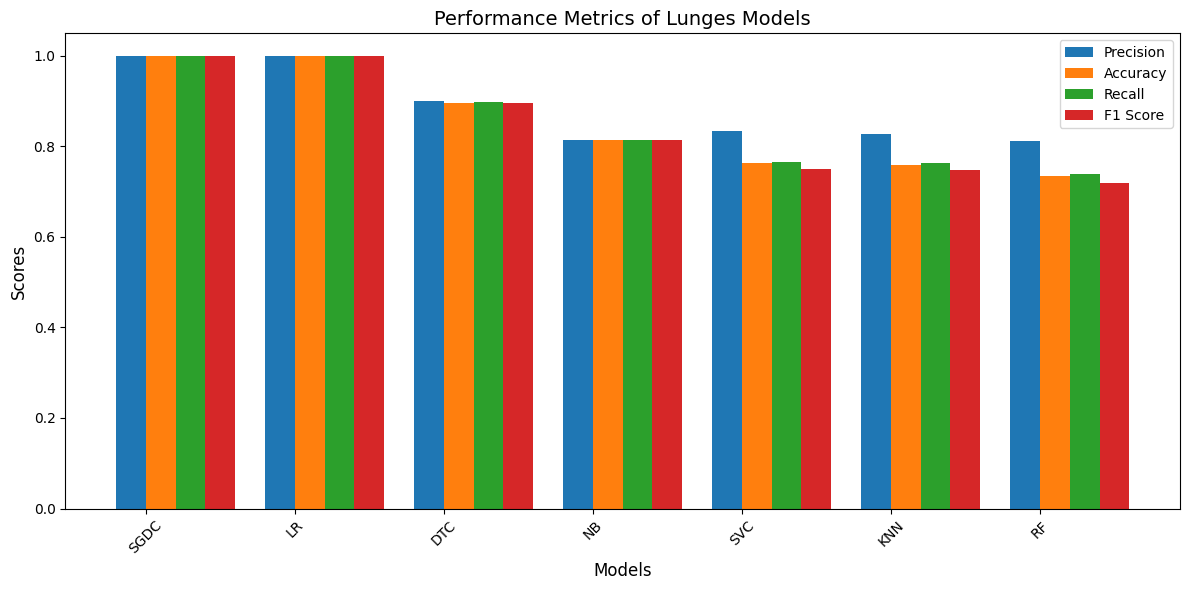

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from testset_final_results
models = [result[0] for result in testset_final_results]
precision = [np.mean(result[1]) for result in testset_final_results]  # Average precision
accuracy = [result[2] for result in testset_final_results]
recall = [np.mean(result[3]) for result in testset_final_results]     # Average recall
f1_score = [np.mean(result[4]) for result in testset_final_results]   # Average F1 score

# Define the metrics and their corresponding labels
metrics = [precision, accuracy, recall, f1_score]
metric_labels = ["Precision", "Accuracy", "Recall", "F1 Score"]

# Create a grouped bar chart
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, metric, width, label=metric_labels[i])

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Performance Metrics of Lunges Models', fontsize=14)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models, rotation=45, fontsize=10)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


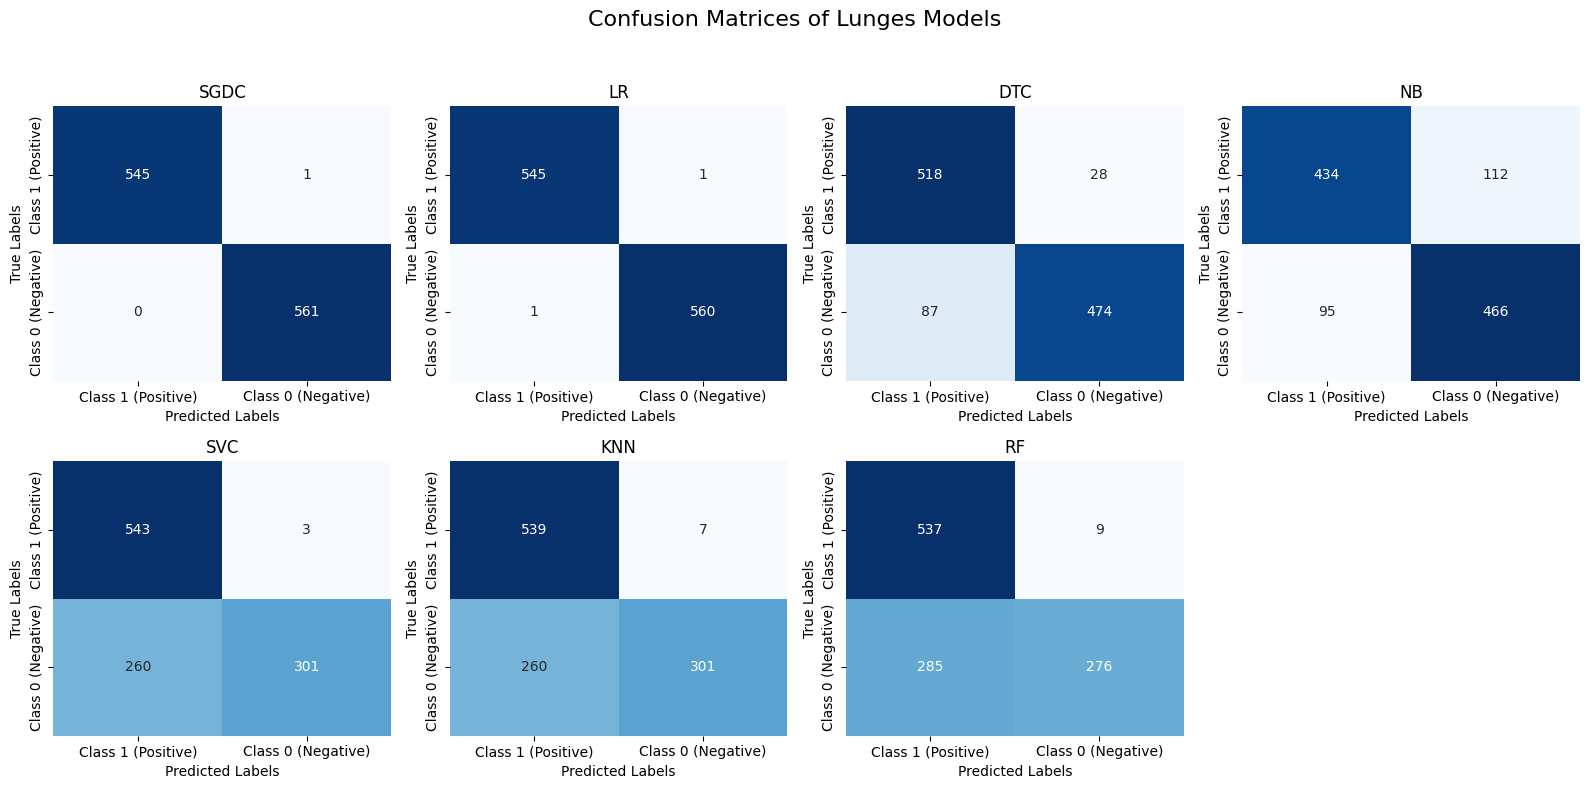

In [51]:
import math
import seaborn as sns

# Calculate rows and columns dynamically
n_models = len(models)  # Number of models
cols = 4  # Number of columns
rows = math.ceil(n_models / cols)  # Calculate rows dynamically

# Create a grid matching the number of models
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, rows * 4))
fig.suptitle("Confusion Matrices of Lunges Models", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, (ax, cm, model) in enumerate(zip(axes, confusion_matrices, models)):
    cm_df = pd.DataFrame(cm, index=["Class 1 (Positive)", "Class 0 (Negative)"],
                            columns=["Class 1 (Positive)", "Class 0 (Negative)"])
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(model, fontsize=12)
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")

# Remove unused subplots
for ax in axes[len(models):]:
    ax.remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [50]:
import os
import pickle
import zipfile
from google.colab import files

# Define the directory and filename for saving the model
model_directory = "/content/Lunges"
model_filename = "err_LR_model.pkl"
model_path = os.path.join(model_directory, model_filename)

# Ensure the directory exists
os.makedirs(model_directory, exist_ok=True)

# Save the model using pickle (assuming 'models["LR"]' is the model you want to save)
with open(model_path, "wb") as f:
    pickle.dump(models["LR"], f)

# Create a zip file containing the saved model
zip_filename = "err_LR_model.zip"
zip_filepath = os.path.join("/content", zip_filename)

# Create a zip file
with zipfile.ZipFile(zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path, os.path.basename(model_path))

# Provide a download link for the zip file
files.download(zip_filepath)

print(f"Model saved and zipped. You can download it from the link above.")


TypeError: list indices must be integers or slices, not str